# G2-Hackathon Scope

### 1. Load Environment Variables


In [2]:
from dotenv import load_dotenv
import os

load_dotenv()
token = os.getenv("API_KEY")

### 2. Get the Review Corpus

In [7]:
import requests

def fetch_reviews(token , number_of_reviews = 5, page_num = 1):
    url = "https://data.g2.com/api/v1/survey-responses"
    headers = {
        "Authorization": f"Token token={token}",
        "Content-Type": "application/vnd.api+json"
    }

    
    params = {

        "page[size]": f"{number_of_reviews}",
        "page[number]": f"{page_num}"  
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()
        return data['data']
    else:
        print(f"Error: {response.status_code} - {response.text}")
        
        return None

reviews = fetch_reviews(token, 100, 1)

### 3. Preprocess the Review Corpus

In [9]:
from datetime import datetime

def change_to_dd_mm_yyyy(rfc3339_date):
    dt_object = datetime.fromisoformat(rfc3339_date)
    return dt_object.strftime('%d%m%Y')

def create_review_dictionary(reviews):
    review_dict = {}
    for review in reviews:
        attributes = review["attributes"]
        review_id = review["id"]
        review_dict[review_id] = {
            "ease_of_doing_business_with": attributes["secondary_answers"]["ease_of_doing_business_with"]["value"] if "ease_of_doing_business_with" in attributes["secondary_answers"] else None,
            "country_name": attributes["country_name"],
            "votes_up": attributes["votes_up"],
            "votes_down": attributes["votes_down"],
            "votes_total": attributes["votes_total"],
            "star_rating": attributes["star_rating"],
            "time": change_to_dd_mm_yyyy(attributes["submitted_at"]),
            "likes": attributes["comment_answers"]["love"]["value"],
            "dislikes": attributes["comment_answers"]["hate"]["value"]
        }
    return review_dict

review_dict = create_review_dictionary(reviews)

In [26]:
likes = []
dislikes = []

for review_id, review in review_dict.items():
    likes.append(review["likes"])
    dislikes.append(review["dislikes"])

### 4. Name Imputation

In [28]:
import spacy

nlp = spacy.load("en_core_web_lg")

def change_name(sentence , name = "SAM" ):
    doc = nlp(sentence)
    replaced_sentence = sentence
    for entity in doc.ents:
        if entity.label_ == "PERSON" :
            replaced_sentence = replaced_sentence.replace(entity.text, "person")
        if entity.label_ == "ORG" :
            replaced_sentence = replaced_sentence.replace(entity.text, "organization")
            
        if entity.text == "G2Crowd" or entity.text == "G2" or entity.text == "G2 Crowd":
            replaced_sentence = replaced_sentence.replace(entity.text, "organization")
    return replaced_sentence

In [29]:
for i in range(0, len(likes)):
    likes[i] = change_name(likes[i])

### 5. Feature Extraction

In [84]:
import requests

API_KEY = os.getenv("HF_KEY")
API_URL = "https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"

headers = {"Authorization": f"Bearer {API_KEY}"}


def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()


def extract_features(review):
    
    preprompt =  "Here is a review : "
    endprompt = "List the features what user liked, give keyword or 2 word phrases only. Give the output in format features: feature1, feature2, feature3, ... " 
    
    response =  query({
	"inputs": preprompt+review+endprompt
})
    
    return response[0]["generated_text"].split(":")[-1].strip()

In [99]:
features =[]
for i in range(0, len(likes)):
    features.append(extract_features(likes[i]).split(','))


In [100]:
copy_features = features

In [101]:
copy_features[0:10]

[['market validation',
  ' pipeline build',
  ' open dialogue',
  ' referrals',
  ' opportunity consideration',
  ' reference calls reduction',
  ' customer validation',
  ' market profile',
  ' positioning.'],
 ['Briefly explain the purpose and benefits of the report',
  ' as well as any methodology'],
 ['user success stories', ' brand building', ' value understanding.'],
 ['* End-to-end service\n* Process implementation assistance\n* Optimization of process\n* Success-oriented approach\n* Consistently improved results\n* Campaign management assistance'],
 ['feature1',
  ' feature2',
  ' feature3',
  ' ... \nExcellent service',
  ' committed to results',
  ' continuous flow of great reviews',
  ' clear vision for innovation in the space.'],
 ['pro-active outreach',
  ' not over-the-top',
  ' great service',
  ' onboarding journey',
  ' available team.'],
 ['automation',
  ' organization',
  ' higher volume',
  ' higher quality',
  ' less work.'],
 ['automated process',
  ' time-saving

### OTHER METHODS

In [184]:

corpus = copy_features

In [192]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import  PorterStemmer, WordNetLemmatizer
import string

# Function for text preprocessing
def preprocess_text(phrase):
    # Tokenization
    res = []
    for i in phrase:
        
        tokens = word_tokenize(i)
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        # Convert to lowercase
        tokens = [word.lower() for word in tokens]
        
        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        tokens = [word.translate(table) for word in tokens]
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        
        # Stem tokens
        #tokens = [stemmer.stem(token) for token in tokens]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [word for word in tokens if not word.isdigit()]

        
        tokens= " ".join(tokens)
                
        res.append(tokens)
    return res

preprocess_t = []
# Preprocess each document in the corpus
for i in range(len(corpus)):
    preprocess_t.append(preprocess_text(corpus[i]))

In [200]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Join preprocessed tokens into strings
corpus_processed = [' '.join(doc) for doc in preprocess_t]

# Create a CountVectorizer object
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the documents
X = vectorizer.fit_transform(corpus_processed)

# Define the number of topics
num_topics = 12

# Create an LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=20, random_state=42)

# Fit the model to the data
lda_model.fit(X)

# Print the topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print()

# Assign topics to documents
topic_assignments = lda_model.transform(X)

# Print topics assigned to each document
for i, doc_topics in enumerate(topic_assignments):
    print(f"Document {i+1}: {doc_topics}")


Topic 0:
data helpful customer response service userfriendly feature3 feature1 feature2 support

Topic 1:
interface review marketing feature3 feature1 feature2 tool support easy responsive

Topic 2:
time ability grid management analytics service platform support organization comparison

Topic 3:
product review comparison easy multiple navigation seamless user setup information

Topic 4:
customer review feature reporting analytics platform management service high process

Topic 5:
lead quality sale higher work automated setup easy time platform

Topic 6:
integration management implementation organization analytics access userfriendly tracking reporting email

Topic 7:
customer review marketing feedback experience user support management solution data

Topic 8:
integration email easy support page userfriendly landing customer campaign interface

Topic 9:
report methodology support tool communication transparent agile review dedicated timesaving

Topic 10:
customer process user sale inter

### TFIDF VECTORIZATION

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Function for text preprocessing
def preprocess_text(phrase):
    # Tokenization
    res = []
    for i in phrase:
        
        tokens = word_tokenize(i)
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        # Convert to lowercase
        tokens = [word.lower() for word in tokens]
        
        # Remove punctuation
        table = str.maketrans('', '', string.punctuation)
        tokens = [word.translate(table) for word in tokens]
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        
        # Stem tokens
        #tokens = [stemmer.stem(token) for token in tokens]
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [word for word in tokens if not word.isdigit()]

        
        tokens= " ".join(tokens)
                
        res.append(tokens)
    return res

preprocessed_dataset = []
# Preprocess each document in the corpus
for i in range(len(corpus)):
    preprocessed_dataset.append(preprocess_text(corpus[i]))

# Flatten the preprocessed dataset
flattened_dataset = [item for sublist in preprocessed_dataset for item in sublist]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(flattened_dataset)

# Calculate pairwise cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# K-means clustering
k = 66 # Number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=k)
kmeans.fit(cosine_sim)

# Extracting important features from each cluster
clusters = {}
for i, label in enumerate(kmeans.labels_):
    if label not in clusters:
        clusters[label] = [flattened_dataset[i]]
    else:
        clusters[label].append(flattened_dataset[i])

# Print out important features in each cluster
for cluster_id, features in clusters.items():
    print(f"Cluster {cluster_id}:")
    for feature in features:
        print(f"- {feature}")
        pass
    print()


NameError: name 'corpus' is not defined

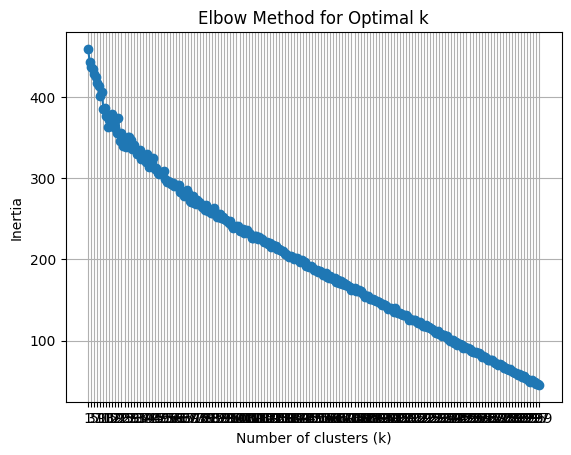

In [127]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

# Function to calculate inertia for a given k
def calculate_inertia(k, tfidf_matrix):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    return kmeans.inertia_

# Define a range of k values to try
k_values = range(1, 300)  # Adjust the range as needed

# Calculate inertia for each k
inertia_values = [calculate_inertia(k, tfidf_matrix) for k in k_values]

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(np.arange(1, 300, 2))  # Adjust x-axis ticks as needed
plt.grid(True)
plt.show()



### 6. Weighting